In [1]:
!pip install tensorflow-datasets

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Graphs

In [2]:
## Helper function to display metric graphs
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])



### Input Pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

print(train_dataset.element_spec)

for example, label in train_dataset.take(1):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [4]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
    print("text: ", example.numpy()[: 3])
    print()
    print("labels: ", label.numpy()[: 3])

text:  [b'This should have been a movie about Sam and his wife, the glorious Peter Falk and equally glorious Olympia Dukakis. That would have been a movie worth seeing. Instead it\'s a Paul Reiser vehicle, with a little Falk thrown in. The wonderful Elizabeth Perkins is also in this movie, but you\'d hardly know it. I presume Reiser is under the impression that he\'s a giant movie star who needs an appropriate vehicle. He\'s not. Even more galling is that Reiser took the trouble to hire some of the best women character actresses on the screen today and then shoved them all into his background. Dukakis does not show up until the last 15 minutes, but when she does, the screen glows. The story is about Falk and Dukakis really, but we\'re subjected to a pointless, silly, preposterous road trip in which Reiser gets to show how very cute, precious and oh-so-deep with psychological insight (wrong!) he can be. For instance, In a restaurant scene that I imagine Reiser had hoped was "Cassavetes-

### Create the text encoder

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[: 20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
encoded_example = encoder(example)[: 3].numpy()
encoded_example

array([[ 11, 139,  26, ...,   0,   0,   0],
       [ 10,  86, 208, ...,   0,   0,   0],
       [ 41, 208,   2, ...,   0,   0,   0]], dtype=int64)

### Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 64,
        mask_zero = True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the model

In [12]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
TF_FORCE_GPU_ALLOW_GROWTH = 1

physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


RuntimeError: Physical devices cannot be modified after being initialized

In [ ]:
print(tf.__version__)

2.7.0


In [13]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu.options.allow_growth = True
session = InteractiveSession(config=config) 

AttributeError: gpu

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 61s 126ms/step - loss: 0.6370 - accuracy: 0.5674 - val_loss: 0.4767 - val_accuracy: 0.7578
Epoch 2/10
391/391 [==============================] - 47s 119ms/step - loss: 0.4173 - accuracy: 0.8089 - val_loss: 0.3803 - val_accuracy: 0.8344
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3568 - accuracy: 0.8436 - val_loss: 0.3540 - val_accuracy: 0.8401
Epoch 4/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3324 - accuracy: 0.8560 - val_loss: 0.3350 - val_accuracy: 0.8542
Epoch 5/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3194 - accuracy: 0.8636 - val_loss: 0.3322 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3130 - accuracy: 0.8663 - val_loss: 0.3284 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 61s 157ms/step - loss: 0.3082 - accuracy: 0.8686 - val_loss: 0.3447 - val_ac

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

391/391 [==============================] - 18s 45ms/step - loss: 0.3188 - accuracy: 0.8537
Test Loss:  0.3188070058822632
Test Accuracy:  0.8536800146102905


(0.0, 0.6536312326788902)

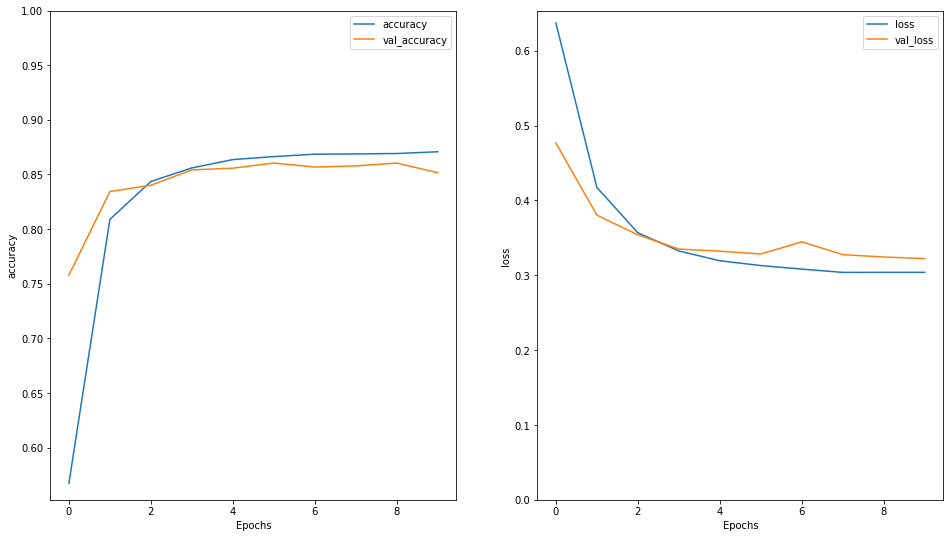

In [18]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, "loss")
plt.ylim(0, None)

### Prediction

In [26]:
sample_text = (r"Because of the laboriousness of the translation process, since the 1940s efforts have been made, with varying degrees of success, to automate translation or \
               to mechanically aid the human translator. More recently, the rise of the Internet has fostered a world-wide market for translation services and has facilitated \
                'language localization'. Ideally, the translator must know both languages, as well as the subject that is to be translated.")

predictions = model.predict(np.array([sample_text]))
predictions

array([[1.9648496]], dtype=float32)

In [27]:
sample_text2 = ("Movies was not inspiring, it shows and content were not upto the marks or not creativity in it. So donot watch this movie it's time waste.")

preds2 = model.predict(np.array([sample_text2]))
preds2

array([[-1.5245659]], dtype=float32)

In [28]:
if(predictions>0.0):
    print("Positive")
else:
    print("Negative")

Positive


In [31]:
## Model Deployement

model_json = model.to_json()
with open('model.json', 'w') as js:
    js.write(model_json)
model.save_weights('model', save_format='tf')